In [1]:
import warnings
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
from numpy.random import normal

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 103

---
## Model 1. Single gene linear model with one covariate

Model the logFC of one gene in multiple cell lines using a single predictor: RNA expression.

$$
logFC \sim Normal(\mu, \sigma) \\
\mu = \alpha + \beta R \\
\alpha \sim \mathcal{N}(0, 10) \\
\beta \sim \mathcal{N}(0, 1) \\
\sigma \sim \text{HalfNormal}(5)
$$

Simulated values:

- number of cell lines: 20
- $\alpha$ = 0.5
- $\beta$ = -1
- $\sigma$ = 0.3

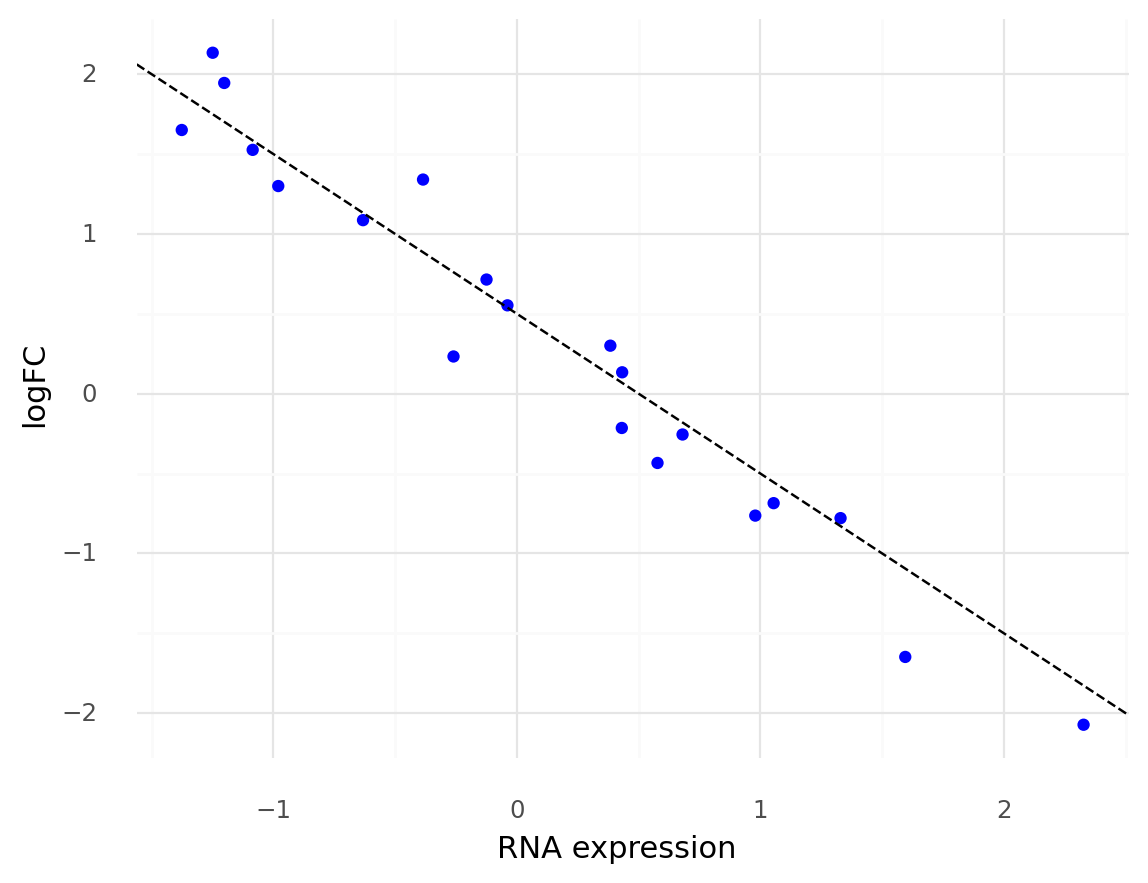

<ggplot: (8789582763710)>

In [2]:
N_CELL_LINES = 20
real_alpha = 0.5
real_beta = -1
real_sigma = 0.3

# Synthetic data
np.random.seed(RANDOM_SEED)
rna = np.random.randn(N_CELL_LINES)
logfc = real_alpha + real_beta * rna + normal(0, real_sigma, N_CELL_LINES)
data = pd.DataFrame({"rna": rna, "logfc": logfc})

(
    gg.ggplot(data, gg.aes("rna", "logfc"))
    + gg.geom_point(color="blue")
    + gg.geom_abline(slope=real_beta, intercept=real_alpha, linetype="--")
    + gg.labs(x="RNA expression", y="logFC")
)

In [3]:
with pm.Model() as model1:
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 1)
    sigma = pm.HalfNormal("sigma", 5)

    mu = pm.Deterministic("mu", alpha + beta * data.rna)

    logfc = pm.Normal("logfc", mu=mu, sigma=sigma, observed=data.logfc)

    model1_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model1_trace = pm.sample(1000)
    model1_post_check = pm.sample_posterior_predictive(
        model1_trace, random_seed=RANDOM_SEED
    )

WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /home/jc604/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-glibc2.10-x86_64-3.8.5-64/tmpdk0b6k2n/key.pkl
INFO (theano.gof.compilelock): Waiting for existing lock by process '29372' (I am process '24256')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jc604/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-glibc2.10-x86_64-3.8.5-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


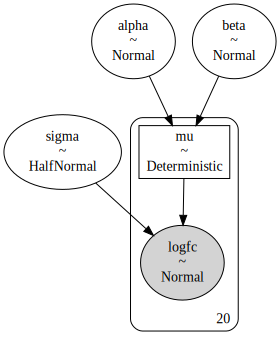

In [4]:
pm.model_to_graphviz(model1)

In [5]:
az_model1 = az.from_pymc3(
    trace=model1_trace,
    posterior_predictive=model1_post_check,
    prior=model1_prior_check,
    model=model1,
)

In [6]:
var_names = ["alpha", "beta", "sigma"]
az.summary(az_model1, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.436,0.063,0.321,0.557,0.001,0.001,3452.0,3452.0,3561.0,2468.0,1.0
beta,-1.100,0.061,-1.215,-0.988,0.001,0.001,3225.0,3225.0,3507.0,2323.0,1.0
sigma,0.273,0.049,0.189,0.366,0.001,0.001,3197.0,2958.0,3419.0,2789.0,1.0


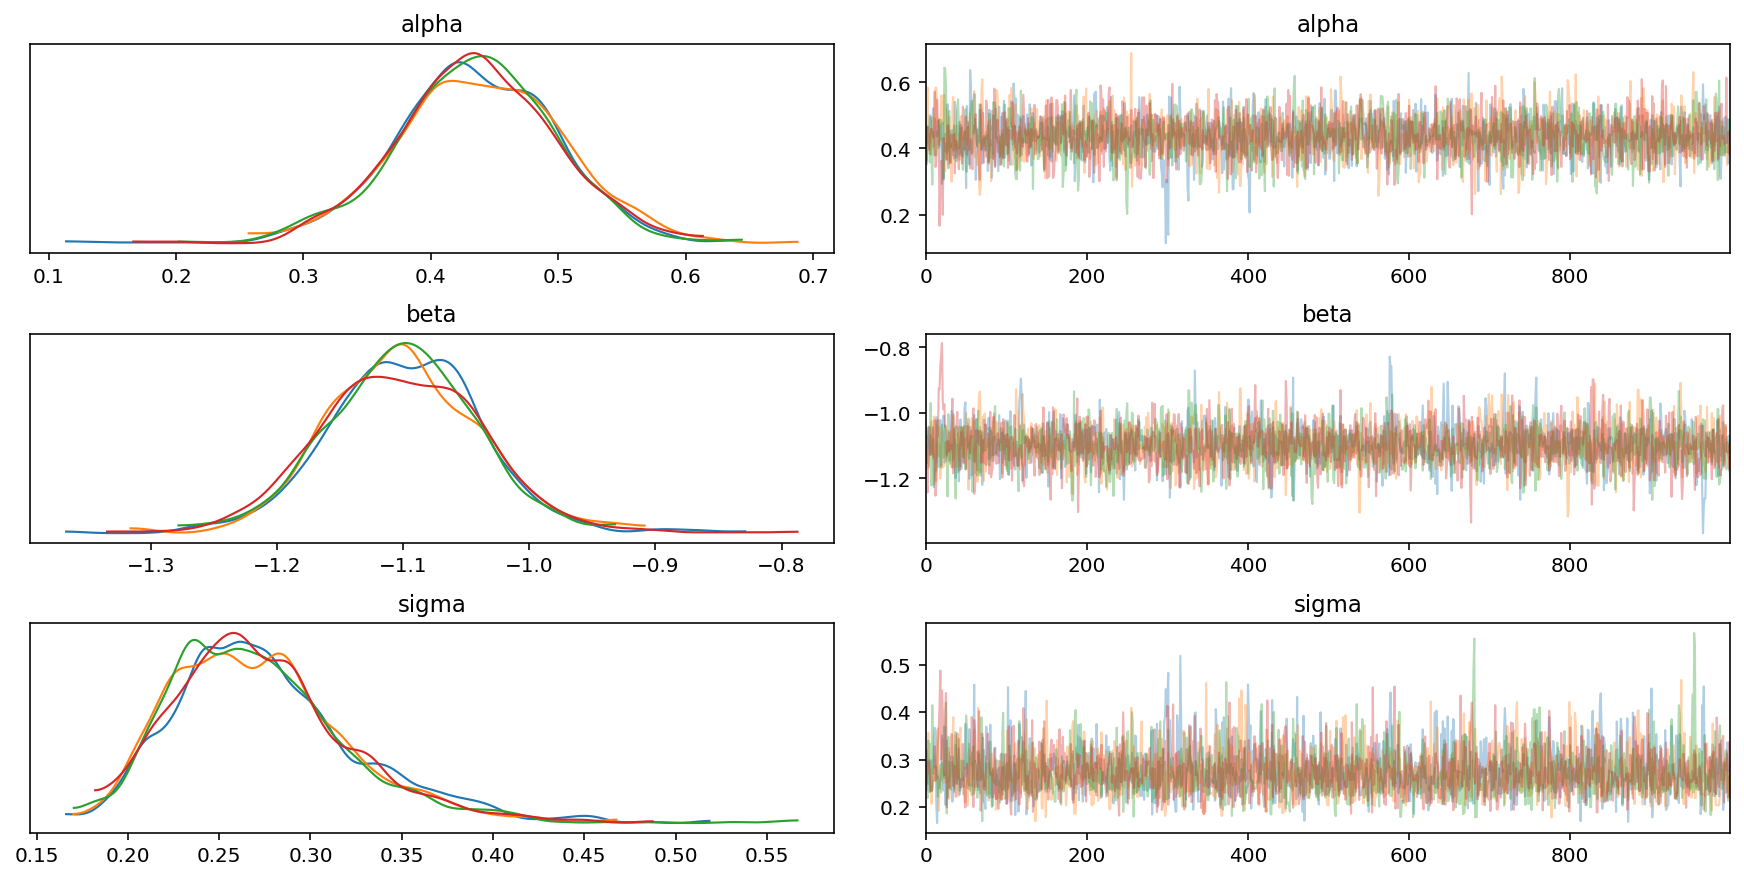

In [7]:
az.plot_trace(az_model1, var_names=var_names)
plt.show()

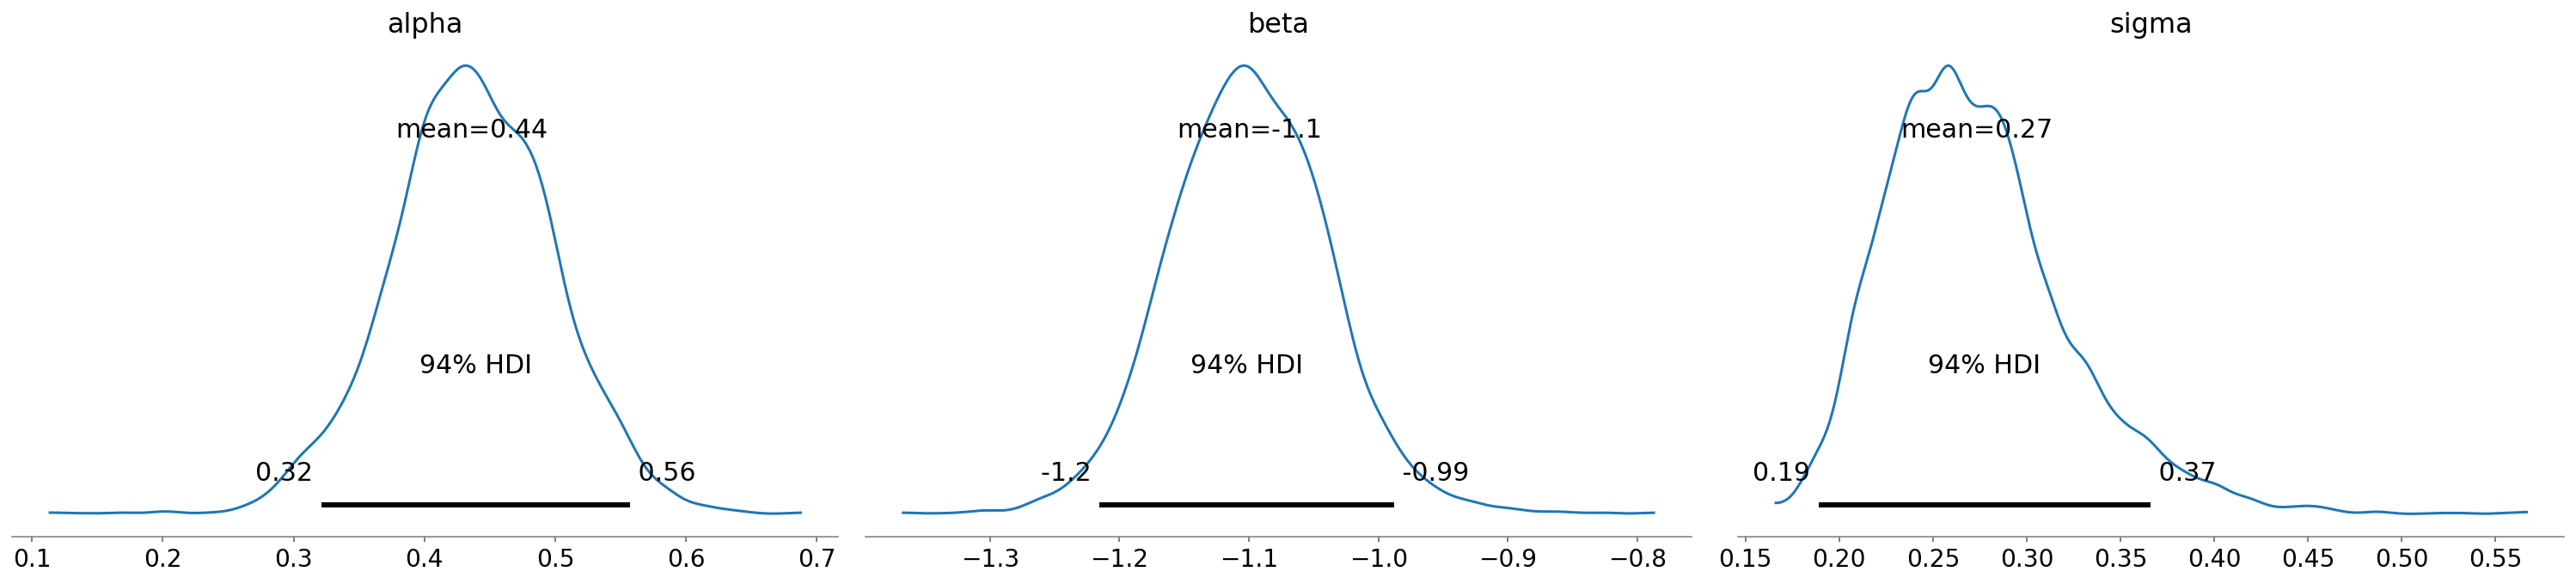

In [8]:
az.plot_posterior(az_model1, var_names=var_names)
plt.show()

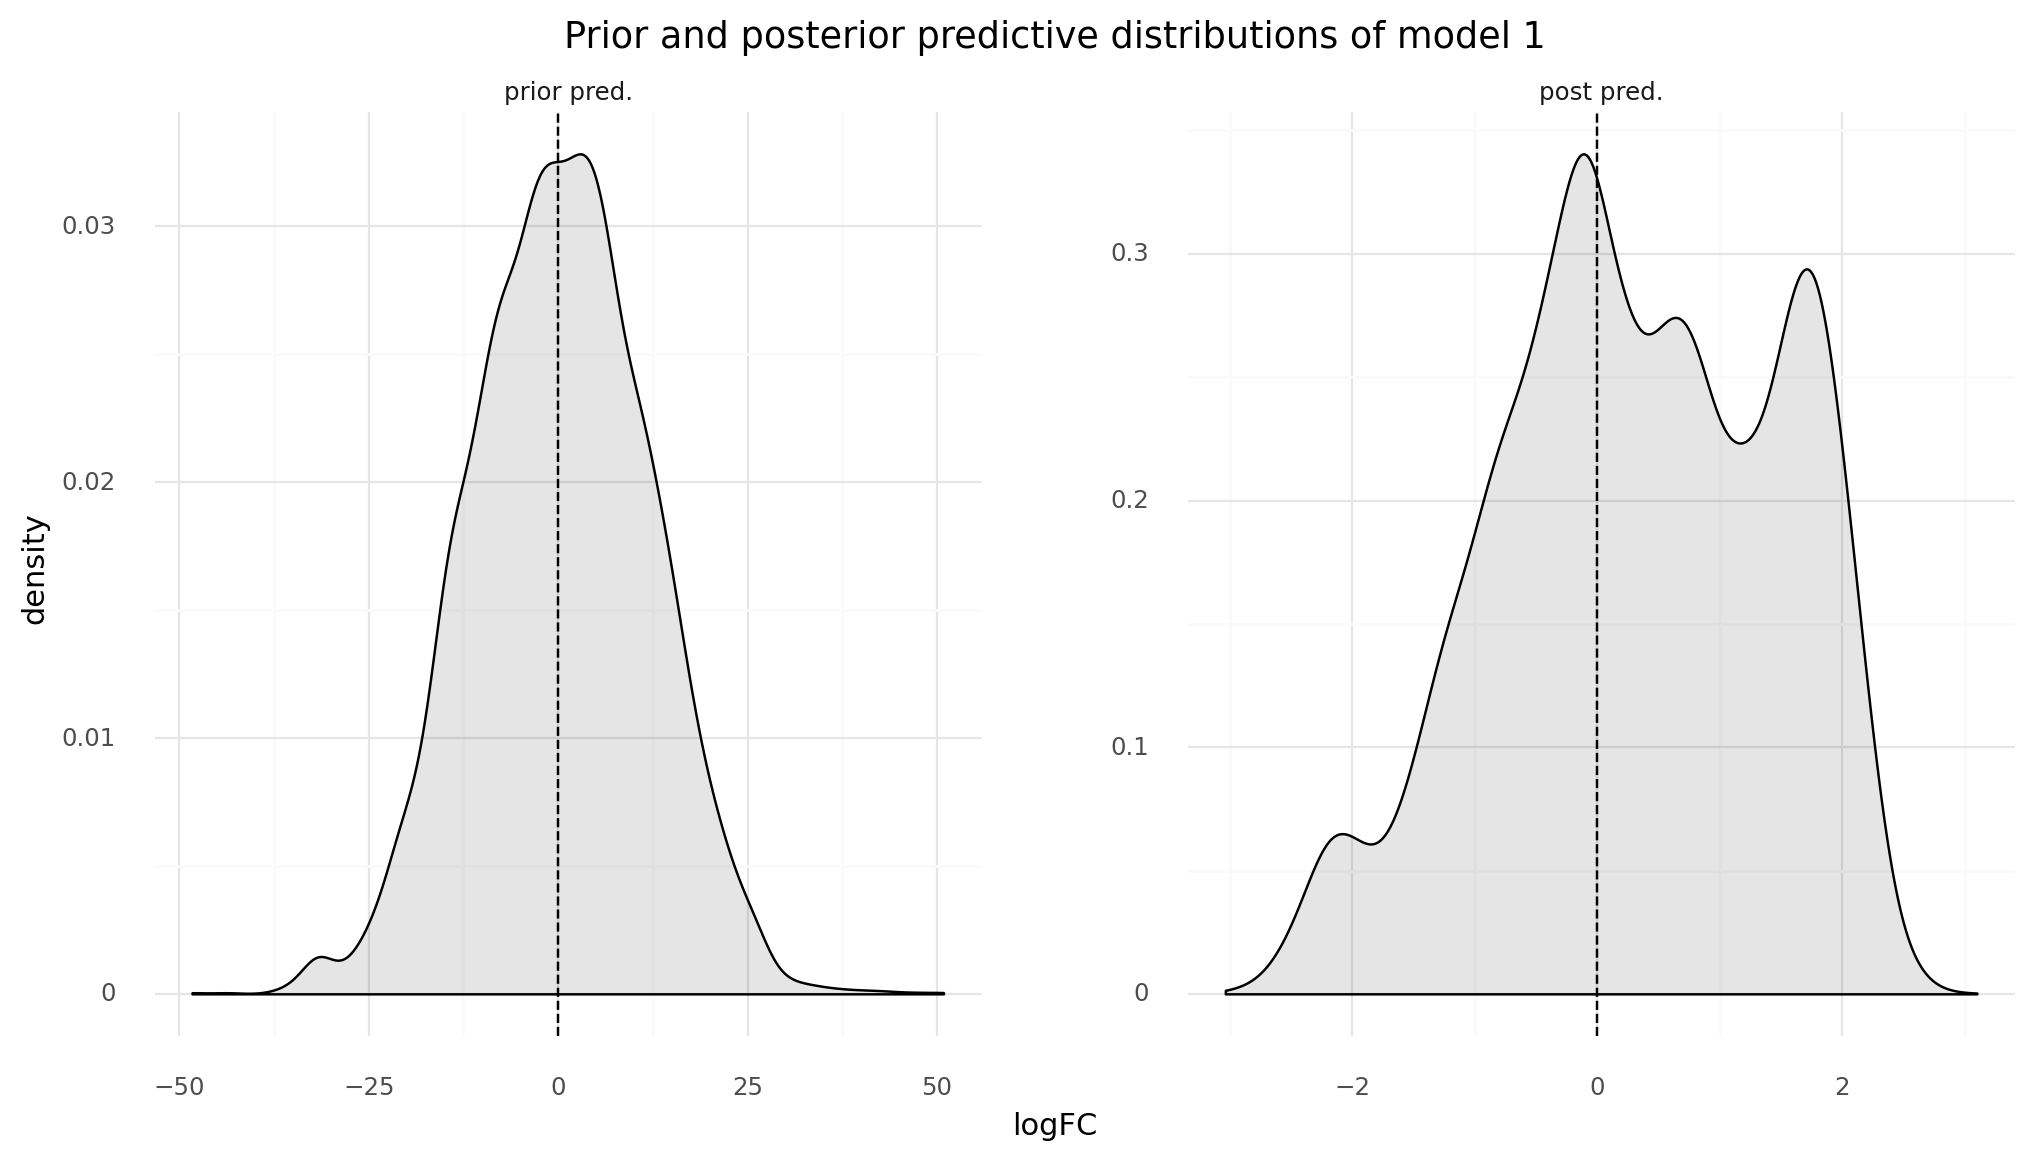

<ggplot: (8789580662797)>

In [9]:
prior_pred = (
    az_model1.prior_predictive.to_dataframe()
    .sample(frac=0.5)
    .assign(pred="prior pred.")
)
post_pred = (
    az_model1.posterior_predictive.to_dataframe()
    .sample(frac=0.2)
    .assign(pred="post pred.")
)
model1_preds = pd.concat([prior_pred, post_pred])
model1_preds["pred"] = pd.Categorical(
    model1_preds.pred, categories=["prior pred.", "post pred."]
)
(
    gg.ggplot(model1_preds, gg.aes("logfc"))
    + gg.facet_wrap("pred", nrow=1, scales="free")
    + gg.geom_density(fill="black", alpha=0.1)
    + gg.geom_vline(xintercept=0, linetype="--")
    + gg.scale_y_continuous(limits=(0, np.nan))
    + gg.labs(
        x="logFC",
        y="density",
        title="Prior and posterior predictive distributions of model 1",
    )
    + gg.theme(figure_size=[12, 6], subplots_adjust={"wspace": 0.25})
)

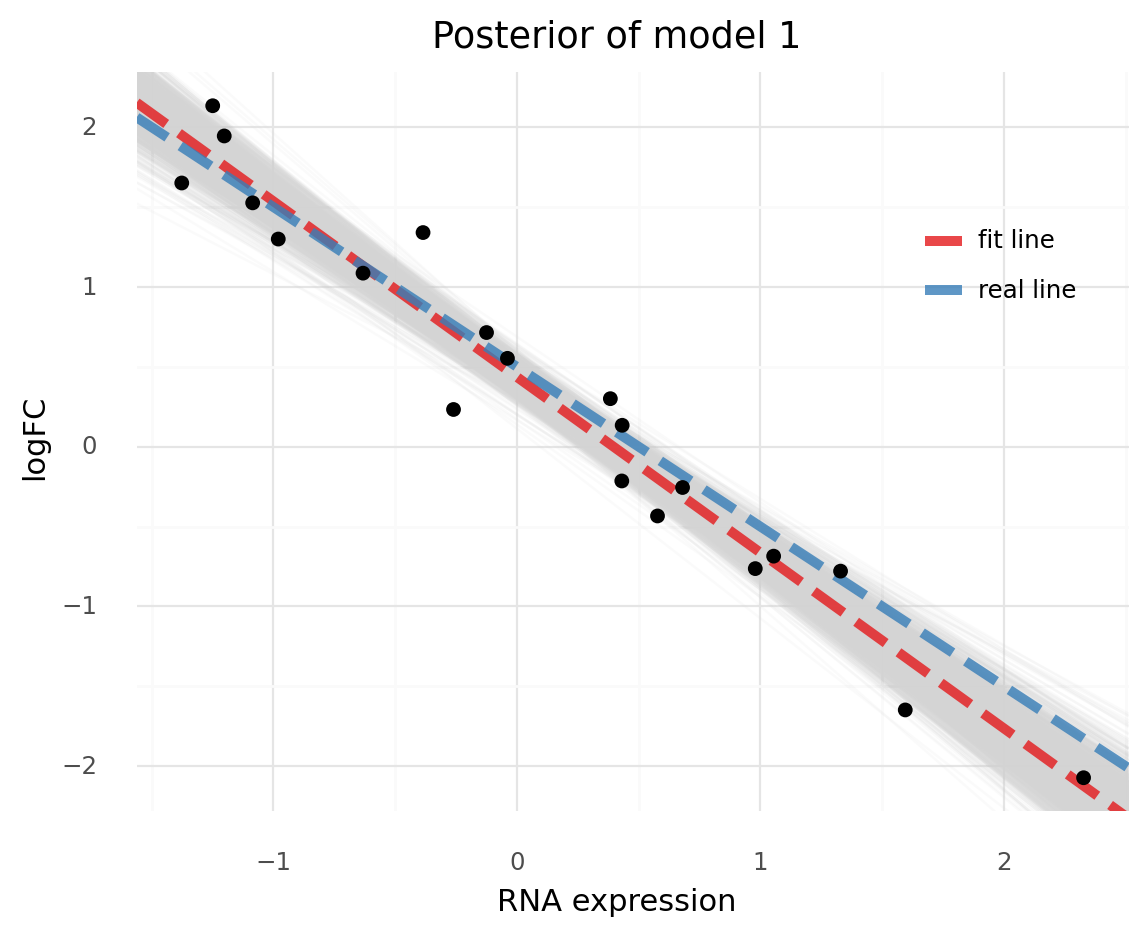

<ggplot: (8789580436074)>

In [10]:
post = az_model1.posterior.to_dataframe()

post_summary = pd.DataFrame(
    {
        "name": ["real line", "fit line"],
        "slope": [real_beta, post.mean()["beta"]],
        "intercept": [real_alpha, post.mean()["alpha"]],
    }
)

(
    gg.ggplot(post.sample(frac=0.1))
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha"), alpha=0.1, color="lightgrey"
    )
    + gg.geom_abline(
        gg.aes(slope="slope", intercept="intercept", color="name"),
        data=post_summary,
        size=2,
        alpha=0.8,
        linetype="--",
    )
    + gg.geom_point(gg.aes(x="rna", y="logfc"), data=data, color="black", size=2)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(legend_position=(0.8, 0.7))
    + gg.labs(x="RNA expression", y="logFC", title="Posterior of model 1", color="")
)

### Conclusions and final thoughts

This model fit well and is easy to interpret. 
Ready to move onto more complex models with more variables and levels.

---

In [11]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 2.81 minutes


In [12]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

arviz    0.10.0
plotnine 0.7.1
pandas   1.1.3
pymc3    3.9.3
seaborn  0.11.0
numpy    1.19.2
last updated: 2020-12-17 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 32
interpreter: 64bit
host name  : compute-a-16-78.o2.rc.hms.harvard.edu
Git branch : subset-data
